# Proyecto final de Aprendizaje Automático
## Autor:
Daniel Useche.
ignaciousecheparedes@gmail.com

Raul Saavedra
raul.saavedra@unet.edu.ve

---
## Descripción
Aplicación de multiclasificadores tipo Bagging y Boosting a la data de pacientes diabéticos extraida de 130 hospitales de los Estados Unidos en el periodo comprendido entre 1999-2008.

El data set original puede encontrarse en el siguiente [enlace](https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008#) o en la dirección: https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008#

Para una explicación detallada de los atributos presentes en el dataset dirigirse a https://www.hindawi.com/journals/bmri/2014/781670/

---

## Cargando el DataSet 

In [117]:
import numpy as np
import pandas as pd 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
diabeticDataSet = pd.read_csv("diabetic_data.csv", header = 0)
diabeticDataSet.tail()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
101761,443847548,100162476,AfricanAmerican,Male,[70-80),?,1,3,7,3,...,No,Down,No,No,No,No,No,Ch,Yes,>30
101762,443847782,74694222,AfricanAmerican,Female,[80-90),?,1,4,5,5,...,No,Steady,No,No,No,No,No,No,Yes,NO
101763,443854148,41088789,Caucasian,Male,[70-80),?,1,1,7,1,...,No,Down,No,No,No,No,No,Ch,Yes,NO
101764,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,...,No,Up,No,No,No,No,No,Ch,Yes,NO
101765,443867222,175429310,Caucasian,Male,[70-80),?,1,1,7,6,...,No,No,No,No,No,No,No,No,No,NO


---
## Preprocesado:

### Eliminación de caracteristicas ruidosas, o con valores faltantes:
Como todo conjunto de datos, el data set utilizado tiene atributos que poseen elementos faltantes en su mayoria, redundantes o ruidosos, como se muestra en la tabla 1 (pág 3) del [documento](https://www.hindawi.com/journals/bmri/2014/781670/) que describe los atributos, los siguientes atributos deben ser depurados del dataset por su cantidad de valores faltantes:
- weight: indica el peso del paciente, pero como su medida no es obligatoria, posee un aproximado de 97% de valores faltantes.
- payer_code: número que indica el tipo de pago realizado por el paciente, 40% de datos faltantes e irrelevante para el análisis.
- medical_specialty: indica la especialidad del médico que brindó la atención, posee 49% de datos faltantes.
- citoglipton, examide: Estas dos variables se eliminaron porque poseen los mismos valores a lo largo de todo dataset

In [118]:
diabeticDataSet = diabeticDataSet.drop(columns = ['weight', 'payer_code', 'medical_specialty', 'citoglipton', 'examide'])

### Estableciendo un registro único por paciente:
Tambien hay que tomar en cuenta que puede existir mas de un registro para el mismo paciente, por lo que se tomará el atributo **patient_nbr** para filtrar los encuentros y así no existan pacientes duplicados:

In [119]:
diabeticDataSet = diabeticDataSet.drop_duplicates(subset='patient_nbr')

### Vista preliminar del dataset:

In [120]:
diabeticDataSet.T

,0,1,2,3,4,5,6,7,8,9,...,101748,101749,101751,101752,101753,101754,101755,101756,101758,101765
encounter_id,2278392,149190,64410,500364,16680,35754,55842,63768,12522,15738,...,443811536,443816024,443835140,443835512,443841992,443842016,443842022,443842070,443842340,443867222
patient_nbr,8222157,55629189,86047875,82442376,42519267,82637451,84259809,114882984,48330783,63555939,...,189481478,106392411,175326800,139605341,184875899,183087545,188574944,140199494,120975314,175429310
race,Caucasian,Caucasian,AfricanAmerican,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,...,Caucasian,Caucasian,Caucasian,Other,Other,Caucasian,Other,Other,Caucasian,Caucasian
gender,Female,Female,Female,Male,Male,Male,Male,Male,Female,Female,...,Female,Female,Male,Female,Male,Female,Female,Female,Female,Male
age,[0-10),[10-20),[20-30),[30-40),[40-50),[50-60),[60-70),[70-80),[80-90),[90-100),...,[40-50),[70-80),[70-80),[40-50),[40-50),[70-80),[40-50),[60-70),[80-90),[70-80)
admission_type_id,6,1,1,1,1,2,3,1,2,3,...,1,3,3,3,1,1,1,1,1,1
discharge_disposition_id,25,1,1,1,1,1,1,1,1,3,...,4,6,6,1,1,1,1,1,1,1
admission_source_id,1,7,7,7,7,2,2,7,4,4,...,7,1,1,1,7,7,7,7,7,7
time_in_hospital,1,3,2,2,1,3,4,5,13,12,...,14,3,13,3,13,9,14,2,5,6
num_lab_procedures,41,59,11,44,51,31,70,73,68,33,...,69,27,77,13,51,50,73,46,76,13


### Transformación de valores faltantes con el formato '?' a un valor compatible Nan
La Mayoría de los algoritmos de aprendizaje requieren que sus entradas no posean valores faltantes, y no funcionarán si este requerimiento es violado [ref](https://scikit-learn.org/stable/modules/impute.html#impute).

In [121]:
diabeticDataSet = diabeticDataSet.replace('?', np.nan)

In [122]:
for col in diabeticDataSet.columns:
    imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    imp.fit(diabeticDataSet[[col]])
    diabeticDataSet[col] = imp.fit_transform(diabeticDataSet[[col]])
diabeticDataSet

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,41,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,59,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101754,443842016,183087545,Caucasian,Female,[70-80),1,1,7,9,50,...,No,Steady,No,No,No,No,No,Ch,Yes,>30
101755,443842022,188574944,Other,Female,[40-50),1,1,7,14,73,...,No,Up,No,No,No,No,No,Ch,Yes,>30
101756,443842070,140199494,Other,Female,[60-70),1,1,7,2,46,...,No,Steady,No,No,No,No,No,No,Yes,>30
101758,443842340,120975314,Caucasian,Female,[80-90),1,1,7,5,76,...,No,Up,No,No,No,No,No,Ch,Yes,NO


In [123]:
#Function to map values of diag_1, diag_2, diag_3
def categorizeICD9(x):
    if 'V' in str(x):
        return 'Supplementary Classification of External Causes of Injury and Poisoning'
    elif "E" in str(x):
        return 'Supplementary Classification of Factors influencing Health Status and Contact with Health Services'
    num = int(float(x))
    if num >= 0 and num <= 139:
        return "Infectious and Parasitic Diseases"
    if num >=140 and num<= 239:
        return 'Neoplasms'
    if num >= 240 and num<= 279:
        return 'Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders'
    if num >=280 and num<=289:
        return 'Diseases of the Blood and Blood-forming Organs'
    if num >=290 and num<=319:
        return 'Mental Disorders'
    if num >=320 and num<=389:
        return 'Diseases of the Nervous System and Sense Organs'
    if num >= 390 and num<= 459:
        return 'Diseases of the Circulatory System'
    if num >=460 and num<= 519:
        return 'Diseases of the Respiratory System'
    if num >= 520 and num<= 579:
        return 'Diseases of the Digestive System'
    if num >=580 and num<= 629:
        return 'Diseases of the Genitourinary System'
    if num >= 630 and num<= 679:
        return 'Complications of Pregnancy, Childbirth, and the Puerperium'
    if num >= 680 and num<= 709:
        return 'Diseases of the Skin and Subcutaneous Tissue'
    if num>=710 and num<= 739:
        return 'Diseases of the Musculoskeletal System and Connective Tissue'
    if num >=740 and num<=759:
        return 'Congenital Anomalies'
    if num >=760 and num<=779:
        return 'Certain Conditions originating in the Perinatal Period'
    if num >=780 and num<= 799:
        return 'Symptoms, Signs and Ill-defined Conditions'
    if num>=800 and num<= 999:
        return 'Injury and Poisoning'
    else:
        return 'Others'

In [124]:
diabeticDataSet.gender.value_counts()


Female             38025
Male               33490
Unknown/Invalid        3
Name: gender, dtype: int64

In [125]:
diabeticDataSet.age.value_counts()

[70-80)     18210
[60-70)     15960
[50-60)     12466
[80-90)     11589
[40-50)      6878
[30-40)      2699
[90-100)     1900
[20-30)      1127
[10-20)       535
[0-10)        154
Name: age, dtype: int64

/home/raul/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


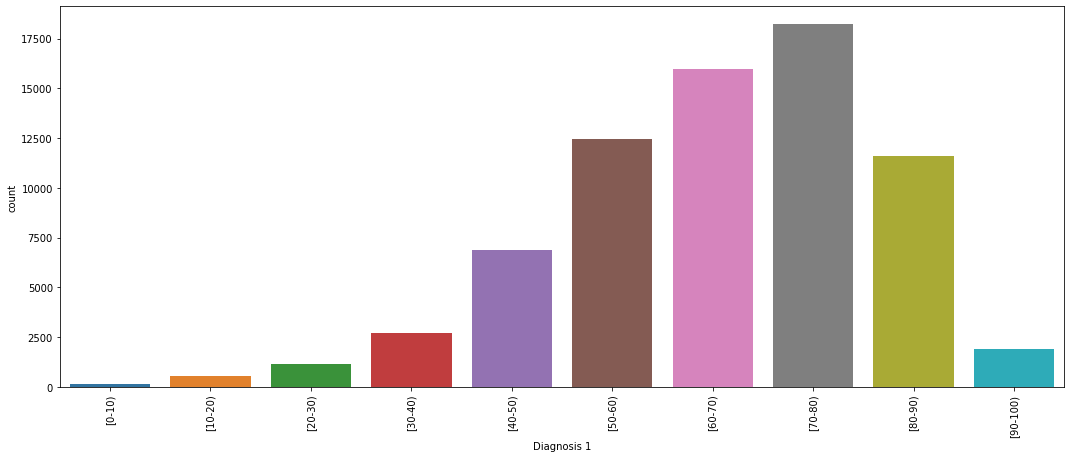

In [126]:
f, ax = plt.subplots(figsize = (18,7))
sns.countplot(diabeticDataSet['age'])
plt.xticks(rotation = 90)
#plt.legend(title = 'Diagnosis', loc = 'upper right', labels = ['A','B'])
plt.xlabel('Diagnosis 1')
plt.show()

In [127]:
diabeticDataSet['diag_1'] = diabeticDataSet['diag_1'].apply(categorizeICD9)
diabeticDataSet['diag_2'] = diabeticDataSet['diag_2'].apply(categorizeICD9)
diabeticDataSet['diag_3'] = diabeticDataSet['diag_3'].apply(categorizeICD9)


/home/raul/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


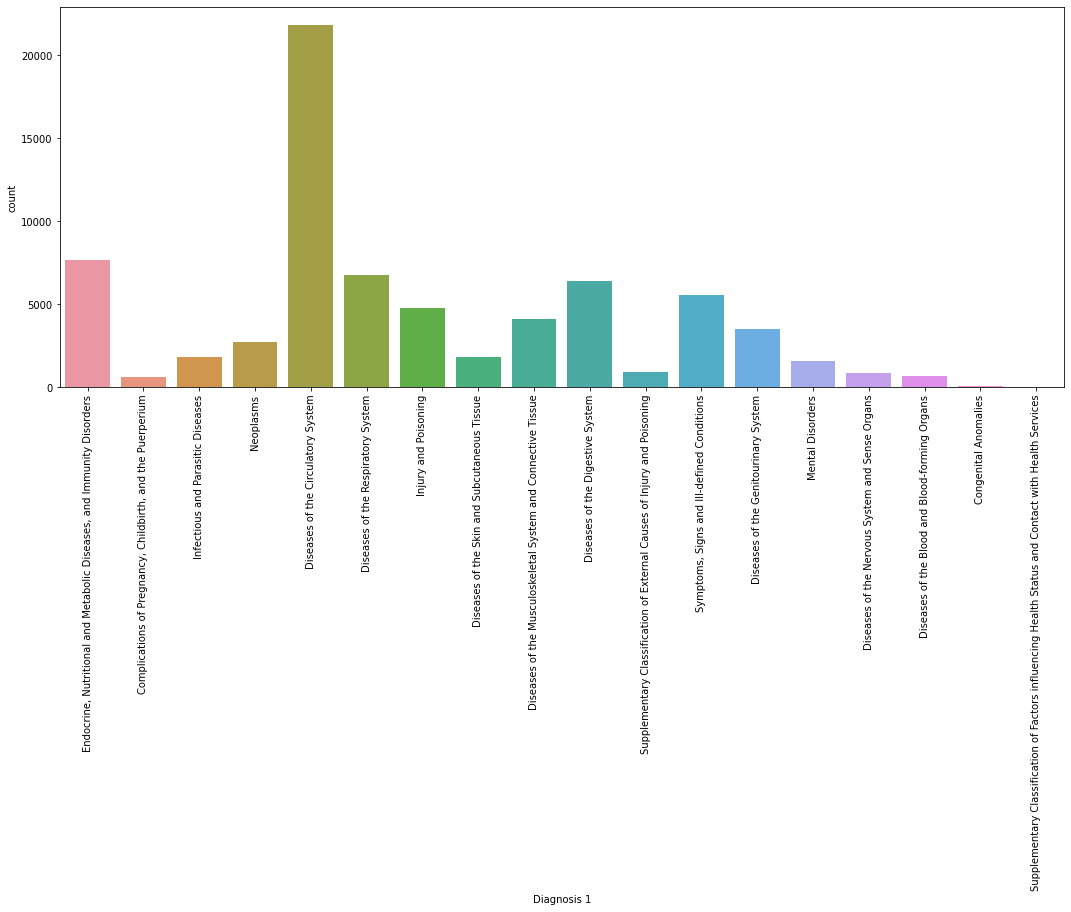

In [128]:
f, ax = plt.subplots(figsize = (18,7))
sns.countplot(diabeticDataSet['diag_1'])
plt.xticks(rotation = 90)
#plt.legend(title = 'Diagnosis', loc = 'upper right', labels = ['A','B'])
plt.xlabel('Diagnosis 1')
plt.show()

In [129]:

origDiabeticDataSet = diabeticDataSet.copy()
for col in diabeticDataSet.columns:
    if diabeticDataSet[col].dtypes == 'object':
        enc = preprocessing.OrdinalEncoder()
        aux = enc.fit(diabeticDataSet[[col]])
        diabeticDataSet[col] = enc.transform(diabeticDataSet[[col]])

/home/raul/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


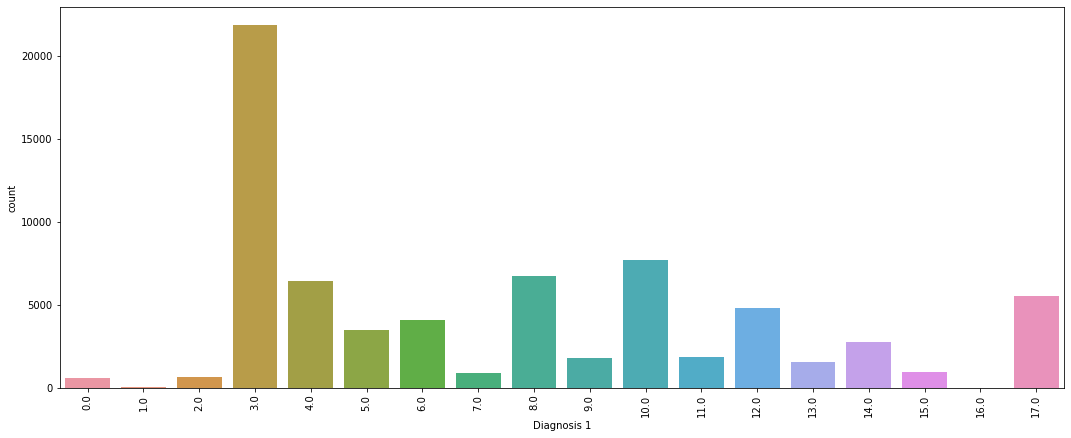

In [130]:
f, ax = plt.subplots(figsize = (18,7))
sns.countplot(diabeticDataSet['diag_1'])
plt.xticks(rotation = 90)
#plt.legend(title = 'Diagnosis', loc = 'upper right', labels = ['A','B'])
plt.xlabel('Diagnosis 1')
plt.show()

In [ ]:
pd.DataFrame.to_csv(diabeticDataSet, "dataPreprocesada.csv")